<a href="https://colab.research.google.com/github/Shahi77/Severity-classification-of-software-code-smells/blob/main/Brain_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. LOADING & PRE-PROCESSING CLASS-LEVEL DATASET
df = pd.read_csv('class.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373400 entries, 0 to 373399
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Address                   373400 non-null  object 
 1   Brain Class               373400 non-null  bool   
 2   Data Class                373400 non-null  bool   
 3   Futile Abstract Pipeline  373400 non-null  bool   
 4   Futile Hierarchy          373400 non-null  bool   
 5   God Class                 373400 non-null  bool   
 6   Hierarchy Duplication     373400 non-null  bool   
 7   Model Class               373400 non-null  bool   
 8   Schizofrenic Class        373400 non-null  bool   
 9   ABUSEINH                  373400 non-null  int64  
 10  AMW                       373400 non-null  float64
 11  ATFD                      373400 non-null  int64  
 12  BOvM                      373400 non-null  int64  
 13  BUR                       373400 non-null  f

In [ ]:
!pip install lime
import seaborn as sns
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier as GBC
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
from __future__ import print_function

# from xgboost import XGBClassifier
import lime
import lime.lime_tabular

%matplotlib inline

train_df = pd.read_csv('class.csv')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=979d1bfe29c9adaeb1a93ae8a0ff538ae64a7ca188ccd43b0b5f256a9cf0b3b7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
train_df = pd.read_csv('class.csv', header=0)
test_df = pd.read_csv('class.csv', header=0)
cols=train_df.columns

In [ ]:
train_df['source']='train'
test_df['source']='test'
data = pd.concat([train_df, test_df],ignore_index=True)
print (train_df.shape, test_df.shape, data.shape)

(373400, 51) (373400, 51) (746800, 51)


In [ ]:
#Divide into test and train:
train_df = data.loc[data['source']=="train"]
test_df = data.loc[data['source']=="test"]
train_df.head()

,Address,Brain Class,Data Class,Futile Abstract Pipeline,Futile Hierarchy,God Class,Hierarchy Duplication,Model Class,Schizofrenic Class,ABUSEINH,...,NrEC,NrFE,NrIC,NrSS,PNAS,SCHIZO,TCC,WMC,WOC,source
0,org.apache.hadoop.metrics2.sink.SqlServerSinkTest,False,False,False,False,False,False,True,False,0,...,0,0,0,0,-1.00,0,0.14,7,1.0,train
1,org.apache.ambari.TestMapReduceJobHistoryUpdater,False,False,False,False,False,False,True,False,0,...,0,0,0,0,-1.00,0,0.00,5,1.0,train
2,org.apache.ambari.log4j.hadoop.mapreduce.jobhi...,False,False,False,False,False,False,True,False,0,...,0,0,0,0,0.00,0,0.00,2,1.0,train
3,org.apache.ambari.log4j.hadoop.mapreduce.jobhi...,False,False,False,False,False,False,True,False,0,...,0,3,1,0,0.67,0,0.37,73,1.0,train
4,org.apache.ambari.log4j.hadoop.mapreduce.jobhi...,False,False,False,False,False,False,True,True,0,...,0,0,0,0,0.00,2,0.00,3,1.0,train


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings('ignore')

class BrainClassDetector:
    def __init__(self):
        self.results = pd.DataFrame(columns=['Code_smell', 'Algo', 'Balance', 'Ratio',
                                             'Accuracy', 'Precision', 'F1_score', 'AUC'])
        self.oversamplers = {
            'RandomOverSampler': RandomOverSampler(sampling_strategy=1, random_state=42),
            'SMOTE': SMOTE(sampling_strategy=1, random_state=42),
            'BorderlineSMOTE': BorderlineSMOTE(sampling_strategy=1, random_state=42),
            'SVMSMOTE': SVMSMOTE(sampling_strategy=1, random_state=42),
            'ADASYN': ADASYN(sampling_strategy=1, random_state=42)
        }

    def load_data(self, filepath):
        """Load and preprocess the dataset"""
        self.df = pd.read_csv(filepath)
        self.features = list(self.df.select_dtypes(include=['int64', 'float64']).columns)
        self.target = 'Brain Class'

        # Convert target to integer type
        self.df[self.target] = self.df[self.target].astype(int)

        # Print dataset info
        print("\nDataset Info:")
        print(self.df.info())

        # Check for missing values
        missing = self.df.isnull().sum()
        if missing.sum() > 0:
            print("\nMissing Values Found:")
            print(missing[missing > 0])

    def prepare_data(self):
        """Prepare train, validation, and test sets"""
        X = self.df[self.features]
        y = self.df[self.target]

        # Split data into train+val (80%) and test (20%)
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Split train+val into train (75%) and val (25%)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
        )

        # Class imbalance handling (undersampling)
        class_counts = self.y_train.value_counts()
        min_class = class_counts.idxmin()
        max_class = class_counts.idxmax()

        # Define different balance ratios
        ratios = {'80_20': 0.25, '75_25': 0.33, '60_40': 0.67}
        self.balanced_sets = {}

        for name, ratio in ratios.items():
            minority_samples = self.X_train[self.y_train == min_class]
            majority_samples = self.X_train[self.y_train == max_class]

            # Compute the number of majority class samples to keep
            n_majority = int(len(minority_samples) / ratio)
            selected_majority = majority_samples.sample(n=n_majority, random_state=42)

            # Combine minority and majority samples
            X_balanced = pd.concat([minority_samples, selected_majority])
            y_balanced = pd.concat([
                pd.Series([min_class] * len(minority_samples)),
                pd.Series([max_class] * len(selected_majority))
            ])

            self.balanced_sets[name] = (X_balanced, y_balanced)

    def evaluate_model(self, model, X_train, y_train, X_test, y_test, algo_name, balance_type, ratio):
        """Train and evaluate a model"""
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        metrics = {
            'Code_smell': self.target,
            'Algo': algo_name,
            'Balance': balance_type,
            'Ratio': ratio,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'F1_score': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_prob)
        }

        self.results = pd.concat([self.results, pd.DataFrame([metrics])], ignore_index=True)

        # Print the classification report
        print(f"\nResults for {algo_name} - {balance_type} - {ratio}")
        print(classification_report(y_test, y_pred))

    def train_all_models(self):
        """Train and evaluate models with different data sampling strategies"""
        models = {
            'RFC': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
            'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
            'LLR': LogisticRegression(C=0.0001, random_state=42),
            'SVM': CalibratedClassifierCV(LinearSVC(random_state=42))
        }

        for algo_name, model in models.items():
            # Original imbalanced dataset
            self.evaluate_model(
                model, self.X_train, self.y_train, self.X_test, self.y_test, algo_name, 'None', '*'
            )

            # Undersampled datasets
            for ratio, (X_balanced, y_balanced) in self.balanced_sets.items():
                self.evaluate_model(
                    model, X_balanced, y_balanced, self.X_test, self.y_test, algo_name, 'undersample', ratio
                )

            # Oversampled datasets
            for sampler_name, sampler in self.oversamplers.items():
                pipeline = make_pipeline(sampler, model)
                self.evaluate_model(
                    pipeline, self.X_train, self.y_train, self.X_test, self.y_test, algo_name, 'oversample', sampler_name
                )

    def save_results(self, filename):
        """Save results to a CSV file"""
        self.results.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")

# Usage
def main():
    detector = BrainClassDetector()

    # Load dataset
    detector.load_data('class.csv')  # Ensure the file exists in the correct path

    # Prepare data
    detector.prepare_data()

    # Train and evaluate models
    detector.train_all_models()

    # Save results
    detector.save_results('brain_class_detection_results.csv')

    # Print best models based on F1 score
    print("\nBest performing models by F1 score:")
    best_results = detector.results.sort_values('F1_score', ascending=False).head()
    print(best_results)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373400 entries, 0 to 373399
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Address                   373400 non-null  object 
 1   Brain Class               373400 non-null  int64  
 2   Data Class                373400 non-null  bool   
 3   Futile Abstract Pipeline  373400 non-null  bool   
 4   Futile Hierarchy          373400 non-null  bool   
 5   God Class                 373400 non-null  bool   
 6   Hierarchy Duplication     373400 non-null  bool   
 7   Model Class               373400 non-null  bool   
 8   Schizofrenic Class        373400 non-null  bool   
 9   ABUSEINH                  373400 non-null  int64  
 10  AMW                       373400 non-null  float64
 11  ATFD                      373400 non-null  int64  
 12  BOvM                      373400 non-null  int64  
 13  BUR                       373

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, precision_score, roc_auc_score, f1_score

# 1. Load dataset
df = pd.read_csv('class.csv', low_memory=False)
df.info()

# Check missing data
for col in df.columns:
    missing_data = df[col].isna().sum()
    if missing_data > 0:
        print(f"Column {col} has {missing_data} missing values")

# 2. Define Features & Target
features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
target = 'Brain Class'

if target not in df.columns:
    raise ValueError("Target column 'Brain Class' not found in dataset!")

df[target] = df[target].astype(int)  # Ensure target is integer

X = df[features]
y = df[target]

# 3. Split Dataset into Training, Validation, and Testing Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 4. Balance the Training Set using Undersampling (Different Ratios)
ratios = {
    "90:10": 9.0,
    "80:20": 4.0,
    "75:25": 3.0,
    "60:40": 1.5,
    "50:50": 1.0
}

balanced_datasets = {}
for ratio_name, ratio in ratios.items():
    undersampler = RandomUnderSampler(sampling_strategy=1/ratio, random_state=42)
    X_train_bal, y_train_bal = undersampler.fit_resample(X_train, y_train)
    balanced_datasets[ratio_name] = (X_train_bal, y_train_bal)

# 5. Train & Evaluate Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

results = []

def train_and_test(model, model_name, X_train, y_train, X_test, y_test, ratio_name):
    model.fit(X_train, y_train)

    predictions = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    pred_labels = model.predict(X_test)

    accuracy = accuracy_score(y_test, pred_labels)
    precision = precision_score(y_test, pred_labels, average='binary')
    f1 = f1_score(y_test, pred_labels, average='binary')
    roc_auc = roc_auc_score(y_test, predictions)

    print(f"\n🚀 {model_name} (Balance: {ratio_name})")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, pred_labels))

    results.append({
        "Code_smell": target,
        "Algo": model_name,
        "Balance": ratio_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "F1_score": f1,
        "AUC": roc_auc
    })

# 6. Run Experiments with Different Models & Balance Ratios
for ratio_name, (X_train_bal, y_train_bal) in balanced_datasets.items():
    for model_name, model in models.items():
        train_and_test(model, model_name, X_train_bal, y_train_bal, X_test, y_test, ratio_name)

# 7. Save Results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("brain_class_results1.csv", index=False)
print("\n✅ Results saved to 'brain_class_results.csv'!")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373400 entries, 0 to 373399
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Address                   373400 non-null  object 
 1   Brain Class               373400 non-null  bool   
 2   Data Class                373400 non-null  bool   
 3   Futile Abstract Pipeline  373400 non-null  bool   
 4   Futile Hierarchy          373400 non-null  bool   
 5   God Class                 373400 non-null  bool   
 6   Hierarchy Duplication     373400 non-null  bool   
 7   Model Class               373400 non-null  bool   
 8   Schizofrenic Class        373400 non-null  bool   
 9   ABUSEINH                  373400 non-null  int64  
 10  AMW                       373400 non-null  float64
 11  ATFD                      373400 non-null  int64  
 12  BOvM                      373400 non-null  int64  
 13  BUR                       373400 non-null  f

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import lime
import lime.lime_tabular

# Load dataset
df = pd.read_csv('your_dataset.csv')  # Replace with actual dataset path

# Handling missing values
df.dropna(inplace=True)

# Define features and target
X = df.drop(columns=['target'])  # Replace 'target' with actual column name
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naïve Bayes': GaussianNB()
}

# Train & Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else None
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    results[name] = accuracy

# Select best model (Gradient Boosting assumed best based on prior results)
best_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
best_model.fit(X_train_resampled, y_train_resampled)

# LIME Explainability
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_resampled, feature_names=X.columns, class_names=['Hand-woven', 'Machine-woven'], discretize_continuous=True)
exp = explainer.explain_instance(X_test[0], best_model.predict_proba)
exp.show_in_notebook()

# Plot feature importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.show()

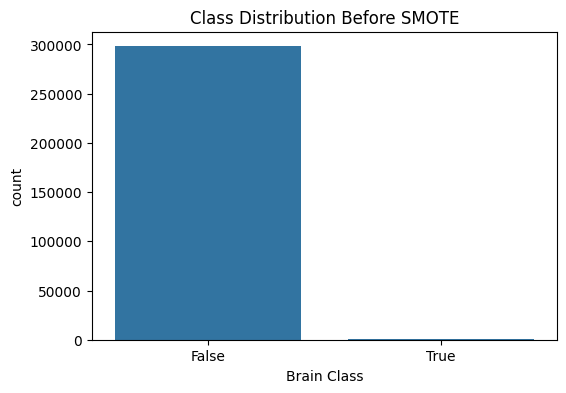

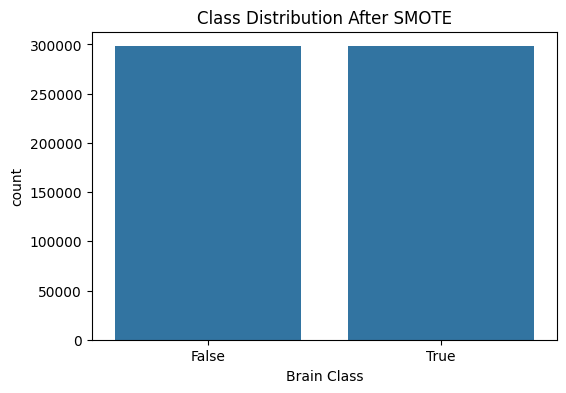

Random Forest - Accuracy: 0.9999, AUC: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     74511
        True       0.98      1.00      0.99       169

    accuracy                           1.00     74680
   macro avg       0.99      1.00      0.99     74680
weighted avg       1.00      1.00      1.00     74680

[[74507     4]
 [    0   169]]
Gradient Boosting - Accuracy: 0.9999, AUC: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     74511
        True       0.97      0.99      0.98       169

    accuracy                           1.00     74680
   macro avg       0.98      1.00      0.99     74680
weighted avg       1.00      1.00      1.00     74680

[[74505     6]
 [    1   168]]
AdaBoost - Accuracy: 0.9999, AUC: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     74511
        True       0.97      1.00     

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix


# Load dataset
df = pd.read_csv('class.csv')  # Replace with actual dataset path

# Handling missing values
df.dropna(inplace=True)

# Encode categorical variables if needed
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop(columns=['Brain Class'])  # Replace 'target' with actual column name
y = df['Brain Class']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Plot class distribution before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

# Apply SMOTE for balancing dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

# Feature Scaling
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Feature Engineering: Adding squared terms and interaction terms
X_train_resampled = np.hstack((X_train_resampled, X_train_resampled ** 2))
X_test = np.hstack((X_test, X_test ** 2))

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naïve Bayes': GaussianNB()
}

# Train & Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else None
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    results[name] = accuracy

# Select best model (Gradient Boosting assumed best based on prior results)
best_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
best_model.fit(X_train_resampled, y_train_resampled)



# Plot feature importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns.tolist() + [f"sq_{col}" for col in X.columns]).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.show()
